In [495]:
import os

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import einops

from tqdm import tqdm
import queue, collections
from torch.autograd import Variable
# import pywt
from sklearn.metrics import precision_recall_curve

In [496]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

In [497]:
def metrics(y_true, y_hat, n_classes):
    y_true_onehot = np.zeros((y_true.shape[0], n_classes))
    y_true_onehot[np.arange(y_true.shape[0]), y_true] = 1
    
    y_hat_onehot = np.zeros((y_hat.shape[0], n_classes))
    y_hat_onehot[np.arange(y_hat.shape[0]), y_hat] = 1
    w = [np.mean(y_true==i) for i in range(n_classes)]

    accuracy = np.mean(y_true == y_hat)
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_hat_onehot[:, i])

    Fw, Fm = 0, 0
    for i in range(n_classes):
        prec = precision[i][1]
        rec = recall[i][1]
        Fw += 2 * w[i] * (prec * rec) / (prec + rec)
        Fm += 2 * (prec * rec) / (prec + rec) / n_classes
    return Fw, Fm, accuracy

In [498]:
class TimeSeriesDataset(Dataset):
    def __init__(self, samples, labels, transforms=None):
        self.samples = samples
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample, target

    def __len__(self):
        return len(self.samples)

In [499]:
# X_train_ = (X_train - X_train.mean(axis=2, keepdims=True)) / X_train.std(axis=2, keepdims=True)
# spectrum_ = np.abs(np.fft.rfft(X_train, axis=2))
# spectrum = np.mean(spectrum_, axis=(0))

In [500]:
# n = spectrum.shape[0]

# fig, ax = plt.subplots(n, 1, figsize=(12, n*0.75))
# for i in range(n):
#     ax[i].plot(spectrum[i])
#     if i == 8:
#         ax[i].set_xlabel('frequency', fontsize=12)
# fig.suptitle('Amplitude', fontsize=16)
# fig.savefig('spectrum')

In [501]:
class Tree:
    def __init__(self, value, n_features):
        self.tree = []
        self.leafs = []
        
        index = np.arange(value.shape[0])
        split = Split(np.sum(value), value, index)
        self.root = split
        
        splits = [split]
        print(splits)
        for i in range(n_features - 1):
            print(splits)
            parent = splits.pop(0)
            split_low, split_high = self.bisection(parent)
            for s in [split_low, split_high]:
                if s.length > 1:
                    splits.append(s)
                else:
                    self.tree.append(s)
            splits = sorted(splits, key=lambda x: x.energy, reverse=True)
        self.tree = self.tree + splits
        self.tree = sorted(self.tree, key=lambda x: x.energy, reverse=True)
        
        for node in self.tree:
            if node.leaf:
                self.leafs.append(node)
        self.leafs = sorted(self.tree, key=lambda x: x.index[0], reverse=False)

    def tree_list(self):
        path = [self.root]
        partitions = []
        while len(path) > 0:
            node = path.pop(0)
            if not node.leaf:
                partition = [0, 0]
                for i, child in enumerate([node.child_low, node.child_high]):
                    if not child.leaf:
                        path.append(child)
                        partition[i] = 1
                partitions.append(partition)
        return partitions
        
    def bisection(self, parent):
        border = parent.length // 2
        value_low, value_high = parent.value[:border], parent.value[border:]
        index_low, index_high = parent.index[:border], parent.index[border:]
        child_low = Split(np.sum(value_low), value_low, index_low, parent=parent)
        child_high = Split(np.sum(value_high), value_high, index_high, parent=parent)
        parent.child_low = child_low
        parent.child_high = child_high
        parent.leaf = False
        return child_low, child_high
    
class Split:
    def __init__(self, energy, value, index, parent=None):
        self.parent = None
        self.leaf = True
        self.child_low = None
        self.child_high = None
        self.energy = energy
        self.value = value
        self.index = index
        self.length = index.shape[0]
        
    def __str__(self):
        return '{}-{}, {}'.format(self.index[0], self.index[-1], self.energy)
    
    def __repr__(self):
        return '{}-{}, {}'.format(self.index[0], self.index[-1], self.energy)

In [502]:
# tree = Tree(spectrum, n_features=10)
# partitions = tree.tree_list()

In [503]:
def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

In [504]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, disable_conv=True):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_planes)
#        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        self.disable_conv = disable_conv
        if not self.disable_conv:
            self.conv1 = nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=1,
                                   padding=0, bias=False)

    def forward(self, x):
        if self.disable_conv:
            return self.relu(self.bn1(x))
        else:
            return self.conv1(self.relu(self.bn1(x)))

In [505]:
class Haar(nn.Module):
    def __init__(self, in_planes, lifting_size, kernel_size, no_bottleneck,
                 share_weights, simple_lifting, regu_details, regu_approx):
        super(Haar, self).__init__()

        self.regu_details = regu_details
        self.regu_approx = regu_approx
        self.share_weights = share_weights

    def forward(self, x):
        x = einops.rearrange(x, 'b t c -> b c t').cpu().detach().numpy()
        
        coef_approx, coef_details = pywt.dwt(x, 'db1')
        approx = get_variable(torch.from_numpy(coef_approx))
        details = get_variable(torch.from_numpy(coef_details))

        ra, rd = 0, 0
        if self.regu_approx > 0:
            ra += self.regu_approx * torch.dist(approx.mean(), x.mean(), p=2)
        if self.regu_details > 0:
            rd = self.regu_details * details.abs().mean()
        r = ra + rd

        return approx, r, details

In [506]:
class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()
        self.conv_even = lambda x: x[:, :, ::2]
        self.conv_odd = lambda x: x[:, :, 1::2]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.conv_even(x), self.conv_odd(x))

In [507]:
class LiftingScheme(nn.Module):
    def __init__(self, in_channels, modified=False, splitting=True, kernel_size=3, dropout = 0, simple_lifting=False):
        super(LiftingScheme, self).__init__()
        self.modified = True
        self.simple_lifting = simple_lifting

        # kernel_size = k_size
        kernel_size = 3
        dilation = 1

        pad = dilation * (kernel_size - 1) // 2

        
        # self.splitting = splitting
        self.split = Splitting()

        # Dynamic build sequential network
        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        # HARD CODED Architecture
        if simple_lifting:
            pad = (kernel_size - 1) // 2
            modules_P += [
                nn.ReflectionPad1d(pad),
                nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=1),
                nn.Tanh()
            ]
            modules_U += [
                nn.ReflectionPad1d(pad),
                nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=1),
                nn.Tanh()
            ]
        else:
            size_hidden = 2

            modules_P += [
                nn.ReflectionPad1d(pad*2),
                nn.Conv1d(in_channels * prev_size, in_channels * size_hidden,
                          kernel_size=kernel_size, dilation=dilation, stride=1),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Dropout(dropout),
                nn.Conv1d(in_channels * size_hidden, in_channels,
                          kernel_size=kernel_size, stride=1),
                nn.Tanh()
            ]
            modules_U += [
                nn.ReplicationPad1d(pad*2),
                nn.Conv1d(in_channels * prev_size, in_channels * size_hidden,
                          kernel_size=kernel_size, dilation=dilation, stride=1),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Dropout(dropout),
                nn.Conv1d(in_channels * size_hidden, in_channels,
                          kernel_size=kernel_size, stride=1),
                nn.Tanh()
            ]
            if self.modified:
                modules_phi += [
                nn.ReplicationPad1d(pad*2),
                nn.Conv1d(in_channels * prev_size, in_channels * size_hidden,
                          kernel_size=kernel_size, dilation=dilation, stride=1),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Dropout(dropout),
                nn.Conv1d(in_channels * size_hidden, in_channels,
                          kernel_size=kernel_size, stride=1),
                nn.Tanh()
            ]
                modules_psi += [
                nn.ReplicationPad1d(pad*2),
                nn.Conv1d(in_channels * prev_size, in_channels * size_hidden,
                          kernel_size=kernel_size, dilation=dilation, stride=1),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Dropout(dropout),
                nn.Conv1d(in_channels * size_hidden, in_channels,
                          kernel_size=kernel_size, stride=1),
                nn.Tanh()
            ]

            self.phi = nn.Sequential(*modules_phi)
            self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        (x_even, x_odd) = self.split(x)

        if not self.modified or self.simple_lifting:
            c = x_even + self.U(x_odd)
            d = x_odd - self.P(c)
            return (c, d)
        else:
            # print(x_odd.shape, x_even.shape)
            # print(self.phi(x_even).shape)
            d = x_odd.mul(torch.exp(self.phi(x_even))) - self.P(x_even)
            c = x_even.mul(torch.exp(self.psi(d))) + self.U(d)
            return (c, d)

In [508]:
class LevelTWaveNet(nn.Module):
    def __init__(self, in_channels, kernel_size, modified, simple_lifting, 
                 regu_details, regu_approx):
        super(LevelTWaveNet, self).__init__()
        self.regu_details = regu_details
        self.regu_approx = regu_approx

        self.wavelet = LiftingScheme(
            in_channels=in_channels, modified=modified,
            kernel_size=kernel_size, simple_lifting=simple_lifting
        )
        
        # self.share_weights = share_weights
        # self.bootleneck = BottleneckBlock(in_channels, in_channels, disable_conv=no_bottleneck)

    def forward(self, x):
        approx, details = self.wavelet(x) #10 9 128

        ra, rd = 0, 0
        if self.regu_approx > 0:
            ra += self.regu_approx * torch.dist(approx.mean(), x.mean(), p=2)
        if self.regu_details > 0:
            rd = self.regu_details * details.abs().mean()
        r = ra + rd

        # approx = self.bootleneck(approx)
            
        return approx, r, details

In [509]:
import torch.nn.functional as F

In [510]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [511]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

                        # 512    8  64    64
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        # if args.share_weight:
        #     print('Attention block share weight!')
        #     self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        # else:
        # print('Attention block NOT share weight!')
        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)
        # if args.temp:
            # print('Attention temporature < 1')
            # self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)
        # else:
            # print('Attention temporature = 1')
        temperature = 1
        self.attention = ScaledDotProductAttention(temperature=temperature)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)
        residual = q
        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        # if  args.share_weight:
        #     k = self.w_qs(k).view(sz_b, len_k, n_head, d_k)
        #     v = self.w_qs(v).view(sz_b, len_v, n_head, d_v)
        # else:
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn

In [512]:
class TWaveNet(nn.Module):
    def __init__(self, 
                 num_classes, 
                 in_channels=9, 
                 extend_channel = 128,
                 number_levels=4,
                 level_part=[[1, 0], [1, 0], [1, 0]],
                 kernel_size=3, 
                 classifier='fc-nn',
                 modified=True,
                 simple_lifting=False,
                 regu_details=0.01, 
                 regu_approx=0.01, 
                 haar_wavelet=False
                ):
        super(TWaveNet, self).__init__()

        self.nb_channels_in = in_channels
        
        # First convolution
        # if first_conv != 3 and first_conv != 9 and first_conv != 22 :
        #     print(first_conv)
        #     self.first_conv = True
        #     self.conv1 = nn.Sequential(
        #         nn.Conv1d(first_conv, extend_channel, kernel_size=3, stride=1, padding=1, bias=False),
        #         nn.BatchNorm1d(extend_channel),
        #         nn.LeakyReLU(negative_slope=0.01, inplace=True),
        #         nn.Dropout(0.5),
        #         nn.Conv1d(extend_channel, extend_channel, kernel_size=3, stride=1, padding=1, bias=False),
        #         nn.BatchNorm1d(extend_channel),
        #         nn.LeakyReLU(negative_slope=0.01, inplace=True),
        #         nn.Dropout(0.5),
        #     )
        #     in_planes = extend_channel
        #     out_planes = extend_channel * (number_levels + 1)
        # else:
        self.first_conv = False
        in_planes = in_channels
        out_planes = in_channels * (number_levels + 1)
        # print(out_planes)

        self.level_part = level_part
        self.levels = nn.ModuleList()
        
        for i in range(number_levels):
            layer = Haar if haar_wavelet else LevelTWaveNet
            module = layer(
                in_channels, kernel_size, modified, simple_lifting, 
                regu_details, regu_approx
            )
            self.levels.add_module('level_' + str(i), module)
            in_planes *= 1

            out_planes += in_planes * 3
        # print(out_planes)
        
        # if no_bootleneck:
        #     in_planes *= 1
        self.num_planes = out_planes


        if classifier == 'linear':
            self.fc = nn.Linear(out_planes, num_classes)
        elif classifier == 'fc-nn':
            self.fc = nn.Sequential(
                nn.Linear(in_planes * (number_levels + 1), 1024),  # Todo:  extend channels
                nn.BatchNorm1d(1024),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Linear(1024, num_classes)
            )
        else:
            raise 'Unknown classifier'

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                n = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
                module.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.bias.data.zero_()
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        n_head = 16
        n_att_channel = 32
        self.atten = MultiHeadAttention(n_head=n_head, d_model=in_planes, d_k=n_att_channel, d_v=n_att_channel, dropout=0)
        self.count_levels = 0
        
    def forward(self, x):
        if self.first_conv:
            x = einops.rearrange(x, 'b t c -> b c t')
            x = self.conv1(x)
            x = einops.rearrange(x, 'b c t -> b t c')
        # print(x.shape)
        regularizers = 0  # List of constrains on details and mean
        features = []  # List of averaged pooled details

        inputs = queue.Queue()
        inputs.put(x)

        for i, level in enumerate(self.levels):
            input_ = inputs.get()
            approx, r, details = level(input_)
            
            if self.level_part[i][0]:
                inputs.put(approx)
            else:
                features.append(self.avgpool(approx))
                
            if self.level_part[i][1]:
                inputs.put(details)
            else:
                features.append(self.avgpool(details))

            regularizers += r
            self.count_levels = self.count_levels + 1

        x = torch.cat(features, 2)
        x = einops.rearrange(x, 'b c t -> b t c')
        q, att = self.atten(x, x, x, mask=None)
        x = q
        x = einops.rearrange(x, 'b c t -> b (c t)')
        return self.fc(x), regularizers

In [513]:
539 / 77

7.0

In [515]:
class Trainer:
    def __init__(self, model, lr=3e-4):
        self.model = model
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)
        self.criterion = nn.CrossEntropyLoss()
        self.train_loss = []
        self.val_loss = []

    def fit(self, dataloader_train, dataloader_val, nepoch=1, use_scheduler=True):
        for epoch in tqdm(range(nepoch)):
            self.model.train()
            train_loss = 0
            for x, y in dataloader_train:
                self.optimizer.zero_grad()
                logits, regularizers = self.model(x)
                loss = self.criterion(logits, y) + torch.sum(regularizers)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.detach().cpu().numpy().item() * x.shape[0]
            self.train_loss.append(train_loss)
            self.scheduler.step()
        
            self.model.eval()
            val_loss = 0
            for x, y in dataloader_val:
                logits, regularizers = self.model(x)
                loss = self.criterion(logits, y) + torch.sum(regularizers)
                val_loss += loss.detach().cpu().numpy().item() * x.shape[0]
            self.val_loss.append(val_loss)
            ys_true, ys_hat = self.predict(dataloader_val)
            
    def predict(self, dataloader_val):
        self.model.eval()
        val_loss = 0
        ys_true, ys_hat = [], []
        for x, y in dataloader_val:
            logits, regularizers = self.model(x)
            y_hat = torch.argmax(logits, dim=1)
            ys_true.append(y)
            ys_hat.append(y_hat)
        ys_true = torch.cat(ys_true).detach().cpu().numpy()
        ys_hat = torch.cat(ys_hat).detach().cpu().numpy()
        return ys_true, ys_hat

## UCI

In [516]:
path_load = 'datasets/HAR/'
train_x = np.load(path_load + 'train_x.npy')
train_y = np.load(path_load + 'train_y.npy')
test_x = np.load(path_load + 'test_x.npy')
test_y = np.load(path_load + 'test_y.npy')

part_HAR = [[1, 0], [1, 1], [1, 1], [1, 0], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0]]
print('HAR level number {}, level details: {}'.format(len(part_HAR), part_HAR))
part_BCICIV2a = [[1, 0], [1, 1], [1, 0], [1, 0], [1, 0], [0, 0], [0, 0]]
print('BCICIV2a level number {}, level details: {}'.format(len(part_BCICIV2a), part_BCICIV2a))
part_NinaPro = [[1, 1], [0, 1], [1, 1], [0, 0], [1, 1], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0]]
print('NinaPro level number {}, level details: {}'.format(len(part_NinaPro), part_NinaPro))
part_OPPOR = [[1, 1], [1, 1], [0, 0], [1, 1], [0, 0], [1, 0], [0, 0], [0, 0]]
print('OPPOR level number {}, level details: {}'.format(len(part_OPPOR), part_OPPOR))

ts_length = train_x.shape[2]
n_ts = train_x.shape[1]
n_classes = np.unique(train_y).shape[0]

HAR level number 9, level details: [[1, 0], [1, 1], [1, 1], [1, 0], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0]]
BCICIV2a level number 7, level details: [[1, 0], [1, 1], [1, 0], [1, 0], [1, 0], [0, 0], [0, 0]]
NinaPro level number 10, level details: [[1, 1], [0, 1], [1, 1], [0, 0], [1, 1], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0]]
OPPOR level number 8, level details: [[1, 1], [1, 1], [0, 0], [1, 1], [0, 0], [1, 0], [0, 0], [0, 0]]


In [517]:
train_x.shape

(7352, 9, 128)

In [518]:
transforms = None
batch_size = 64
dataset_train = TimeSeriesDataset(train_x, train_y, transforms)
dataset_test = TimeSeriesDataset(test_x, test_y, transforms)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, generator=torch.Generator(device='cuda'))
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [522]:
model = TWaveNet(
    num_classes=n_classes, 
    in_channels=n_ts, 
    extend_channel = ts_length,
    number_levels=len(part_HAR),
    level_part=part_HAR,
    kernel_size=3, 
    classifier='fc-nn',
    modified=True,
    simple_lifting=False,
    regu_details=0.1, 
    regu_approx=0.1, 
    haar_wavelet=False
)

In [523]:
trainer = Trainer(model, lr=3e-4)
trainer.fit(dataloader_train, dataloader_test, nepoch=2)

100%|██████████| 2/2 [02:16<00:00, 68.46s/it]


In [524]:
ys_true, ys_hat = trainer.predict(dataloader_test)
np.mean(ys_true == ys_hat)

0.8411944350186631

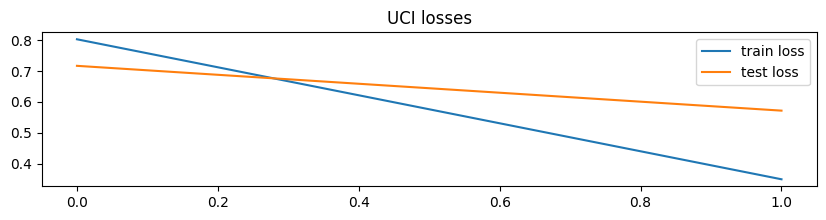

In [525]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(np.asarray(trainer.train_loss) / X_train.shape[0], label='train loss')
ax.plot(np.asarray(trainer.val_loss) / X_test.shape[0], label='test loss')
ax.legend()
ax.set_title('UCI losses')
# fig.savefig('uci_loss')
plt.show()

In [526]:
Fw, Fm, accuracy = metrics(ys_true, ys_hat, n_classes)
print(Fw, Fm, accuracy)

0.8361123786983737 0.8342458826597574 0.8411944350186631


## OPPOR

In [527]:
path_load = 'datasets/OPPOR/'
train_x = np.load(path_load + 'train_x.npy').astype(np.float64)
train_y = np.load(path_load + 'train_y.npy')
test_x = np.load(path_load + 'test_x.npy').astype(np.float64)
test_y = np.load(path_load + 'test_y.npy')

# part_OPPOR = [[1, 1], [1, 1], [0, 0], [1, 1], [0, 0], [1, 0], [0, 0], [0, 0]]
part_OPPOR = [[1, 1], [1, 1], [0, 0], [1, 1], [0, 0], [0, 0], [0, 0]]
print('OPPOR level number {}, level details: {}'.format(len(part_OPPOR), part_OPPOR))

ts_length = train_x.shape[2]
n_ts = train_x.shape[1]
n_classes = np.unique(train_y).shape[0]

OPPOR level number 7, level details: [[1, 1], [1, 1], [0, 0], [1, 1], [0, 0], [0, 0], [0, 0]]


In [528]:
train_x.shape

(41375, 77, 48)

In [529]:
transforms = None
batch_size = 64
dataset_train = TimeSeriesDataset(train_x, train_y, transforms)
dataset_test = TimeSeriesDataset(test_x, test_y, transforms)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, generator=torch.Generator(device='cuda'))
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [530]:
model = TWaveNet(
    num_classes=n_classes, 
    in_channels=n_ts, 
    extend_channel = ts_length,
    number_levels=len(part_OPPOR),
    level_part=part_OPPOR,
    kernel_size=3, 
    classifier='fc-nn',
    modified=True,
    simple_lifting=False,
    regu_details=0.1, 
    regu_approx=0.1, 
    haar_wavelet=False
)

In [ ]:
trainer = Trainer(model, lr=3e-4)
trainer.fit(dataloader_train, dataloader_test, nepoch=100)

  0%|          | 0/100 [00:00<?, ?it/s]

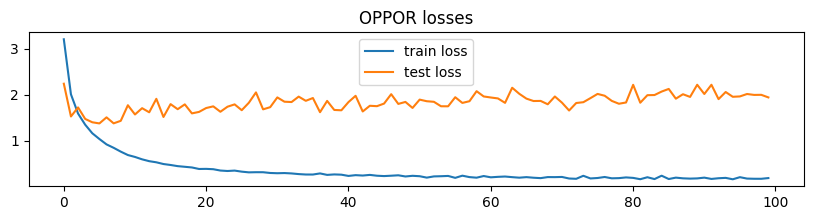

In [482]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(np.asarray(trainer.train_loss) / X_train.shape[0], label='train loss')
ax.plot(np.asarray(trainer.val_loss) / X_test.shape[0], label='test loss')
ax.legend()
ax.set_title('OPPOR losses')
fig.savefig('oppor_loss2')
plt.show()

In [483]:
ys_true, ys_hat = trainer.predict(dataloader_test)
np.mean(ys_true == ys_hat)

0.8920259056871078

In [484]:
Fw, Fm, accuracy = metrics(ys_true, ys_hat, n_classes)
print(Fw, Fm, accuracy)

0.8874364922186864 0.599770844361154 0.8920259056871078


## NinaPro

In [485]:
path_load = 'datasets/NinaPro/'
train_x = np.load(path_load + 'train_x.npy').astype(np.float64)
train_y = np.load(path_load + 'train_y.npy')
test_x = np.load(path_load + 'test_x.npy').astype(np.float64)
test_y = np.load(path_load + 'test_y.npy')

part_NinaPro = [[1, 1], [0, 1], [1, 1], [0, 0], [1, 1], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0]]
# part_NinaPro = [[1, 1], [0, 1], [1, 1], [0, 0], [0, 0], [0, 0]]
print('NinaPro level number {}, level details: {}'.format(len(part_NinaPro), part_NinaPro))

ts_length = train_x.shape[2]
n_ts = train_x.shape[1]
n_classes = np.unique(train_y).shape[0]

NinaPro level number 10, level details: [[1, 1], [0, 1], [1, 1], [0, 0], [1, 1], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0]]


In [486]:
transforms = None
batch_size = 64
dataset_train = TimeSeriesDataset(train_x, train_y, transforms)
dataset_test = TimeSeriesDataset(test_x, test_y, transforms)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, generator=torch.Generator(device='cuda'))
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [487]:
model = TWaveNet(
    num_classes=n_classes, 
    in_channels=n_ts, 
    extend_channel = ts_length,
    number_levels=len(part_NinaPro),
    level_part=part_NinaPro,
    kernel_size=3, 
    classifier='fc-nn',
    modified=True,
    simple_lifting=False,
    regu_details=0.1, 
    regu_approx=0.1, 
    haar_wavelet=False
)

In [488]:
trainer = Trainer(model, lr=3e-4)
trainer.fit(dataloader_train, dataloader_test, nepoch=100)

100%|██████████| 100/100 [53:27<00:00, 32.08s/it]


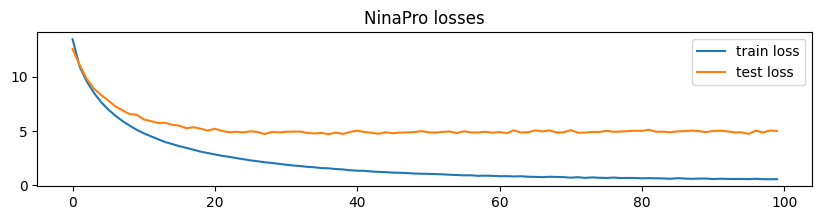

In [489]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(np.asarray(trainer.train_loss) / X_train.shape[0], label='train loss')
ax.plot(np.asarray(trainer.val_loss) / X_test.shape[0], label='test loss')
ax.legend()
ax.set_title('NinaPro losses')
fig.savefig('ninapro_loss')
plt.show()

In [490]:
ys_true, ys_hat = trainer.predict(dataloader_test)
np.mean(ys_true == ys_hat)

0.7495184471773596

In [491]:
Fw, Fm, accuracy = metrics(ys_true, ys_hat, n_classes)
print(Fw, Fm, accuracy)

0.7502767212964495 0.750263745084392 0.7495184471773596
